In [799]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [729]:
# Шаг 1. Загрузка данных и предобработка
file_path = '/Users/danilalipatov/Downloads/resemple_data_cat-last.xlsx'
df = pd.read_excel(file_path)
df["identifier"] = df["identifier"].astype(str)
df.columns

Index(['Unnamed: 0', 'identifier', 'agency', '_ro_type', 'resampled_dates',
       'resampled_values', 'rating_category'],
      dtype='object')

In [730]:
df["resampled_dates"] = pd.to_datetime(df["resampled_dates"])
df_result = df.dropna(subset=["identifier", "resampled_values", "resampled_dates", "agency", "_ro_type"])
# df_result = df_result[(df_result["agency"] == "Expert RA") & (df_result["_ro_type"] == "CBNK - кредитная организация")]
df_result = df_result[(df_result["agency"] == "Expert RA")]
df_result = df_result[df_result["resampled_dates"].dt.year >= 2015]
df_result["resampled_values"] = df_result["resampled_values"].astype(int)
df_result = df_result.groupby("identifier").filter(lambda x: x["resampled_values"].dropna().nunique() > 2)

# Убираем компании, у которых непустых значений меньше порога
threshold = 1  # Например, минимум 10 непустых наблюдений
df_result = df_result.groupby("identifier").filter(lambda x: x["resampled_values"].count() >= threshold)


In [731]:
df_result["identifier"].unique()

array(['7713011336', '7727051787', '6623029538', '5244009279',
       '4401116480', '7707050464', '7701045732', '7835905108',
       '5260059340', '7719780320', '1326024785', '7725520440',
       '7709129705', '3906098008', '7831000027', '7706548313',
       '7729399756', '7804493447', '7705522866', '7750004009',
       '2465029704', '7707492166', '6829000028', '7838408320',
       '4214005204', '1650014919', '2225019491', '7805233787',
       '1657023630', '5250042549', '7702045051', '1435126628',
       '106000547', '1326021671', '1435138944', '7704216908',
       '7705513090', '5402155821', '7716695349', '2310050140',
       '3317000799', '7451032223', '7725497022', '7706196340',
       '7704612010', '7704627560', '7705512995', '5610000466',
       '7714312079', '7725038124', '7704082517', '7453297458',
       '1435159327', '7707067683', '5407249872', '7712034098',
       '7744000912', '7728306068', '7727480641', '8601023568',
       '7703213534', '7705634425', '1101300820', '774400

In [732]:
len(df_result["identifier"].unique())

73

In [734]:
# === Шаг 1. Подготовка данных ===
df_agg = df_result  # Данные уже агрегированы по месяцам

# === Шаг 2. Формирование сводной таблицы (pivot) ===
pivot_df = df_agg.pivot(index="resampled_dates", columns="identifier", values="resampled_values")
# pivot_df = pivot_df.loc[:, pivot_df.count() > 5] 

In [736]:
print(pivot_df)

identifier       106000547  1101300820  1326021671  1326024785  1435126628  \
resampled_dates                                                              
2015-01-31             NaN         NaN         NaN         NaN         NaN   
2015-02-28             NaN         NaN         NaN         NaN         NaN   
2015-03-31             NaN         NaN         NaN         NaN         NaN   
2015-04-30             NaN         NaN         NaN         NaN         NaN   
2015-05-31             NaN         NaN         NaN         NaN         NaN   
...                    ...         ...         ...         ...         ...   
2024-07-31             4.0         5.0         7.0         5.0         7.0   
2024-08-31             4.0         5.0         7.0         5.0         7.0   
2024-09-30             4.0         5.0         7.0         5.0         7.0   
2024-10-31             4.0         5.0         7.0         5.0         7.0   
2024-11-30             5.0         6.0         7.0         5.0  

In [737]:
total_nan = pivot_df.isna().sum().sum()
print(f"Общее количество NaN: {total_nan}")
# pivot_df = pivot_df.loc[:, pivot_df.nunique(dropna=True) > 1]

Общее количество NaN: 2190


In [738]:
correlation = pivot_df["106000547"].corr(pivot_df["1101300820"])
print(f"Корреляция между 106000547 и 1101300820: {correlation:.4f}")
print(pivot_df["106000547"].unique(), pivot_df["1101300820"].unique())

Корреляция между 106000547 и 1101300820: 0.2990
[nan  3.  4.  5.] [nan  4.  5.  6.]


In [739]:
# Проверяем количество ненулевых значений
print(pivot_df[["106000547", "1101300820"]].count())

# Проверяем дисперсию
print(pivot_df[["106000547", "1101300820"]].var())
df_corr = pivot_df[["106000547", "1101300820"]].dropna(how="any")
correlation = df_corr["106000547"].corr(df_corr["1101300820"], method="spearman")
print(f"Корреляция между 106000547 и 1101300820: {correlation:.4f}")
print(pivot_df["106000547"].dropna().unique(), pivot_df["1101300820"].dropna().unique())

identifier
106000547     94
1101300820    82
dtype: int64
identifier
106000547     0.109014
1101300820    0.256098
dtype: float64
Корреляция между 106000547 и 1101300820: 0.2255
[3. 4. 5.] [4. 5. 6.]


In [740]:
len(pivot_df.columns) * len(pivot_df)

8687

In [741]:
pivot_df.dtypes
print(pivot_df.notna().sum())
print(pivot_df.var())
print(pivot_df.nunique())

identifier
106000547     94
1101300820    82
1326021671    94
1326024785    96
1435126628    94
              ..
7835905108    96
7838408320    95
8601023568    87
8601027509    80
9718077239    36
Length: 73, dtype: int64
identifier
106000547     0.109014
1101300820    0.256098
1326021671    1.372684
1326024785    0.546382
1435126628    1.327499
                ...   
7835905108    0.587719
7838408320    1.079059
8601023568    0.557605
8601027509    0.458070
9718077239    0.650000
Length: 73, dtype: float64
identifier
106000547     3
1101300820    3
1326021671    3
1326024785    3
1435126628    4
             ..
7835905108    3
7838408320    3
8601023568    4
8601027509    3
9718077239    3
Length: 73, dtype: int64


Cross-Correlation Matrix (Pearson) between Companies (INN):
identifier  106000547  1101300820  1326021671  1326024785  1435126628  \
identifier                                                              
106000547    1.000000    0.225540    0.415638    0.598519    0.756819   
1101300820   0.225540    1.000000    0.759882    0.813623    0.332066   
1326021671   0.415638    0.759882    1.000000    0.746020    0.617332   
1326024785   0.598519    0.813623    0.746020    1.000000    0.732919   
1435126628   0.756819    0.332066    0.617332    0.732919    1.000000   
...               ...         ...         ...         ...         ...   
7835905108   0.587428    0.785892    0.747316    0.979248    0.755071   
7838408320   0.785498    0.206042    0.548249    0.703681    0.910807   
8601023568  -0.430065   -0.659181   -0.689053   -0.815301   -0.694445   
8601027509  -0.142260   -0.665990   -0.764434   -0.644563   -0.320217   
9718077239  -0.167088   -0.167088         NaN         NaN       

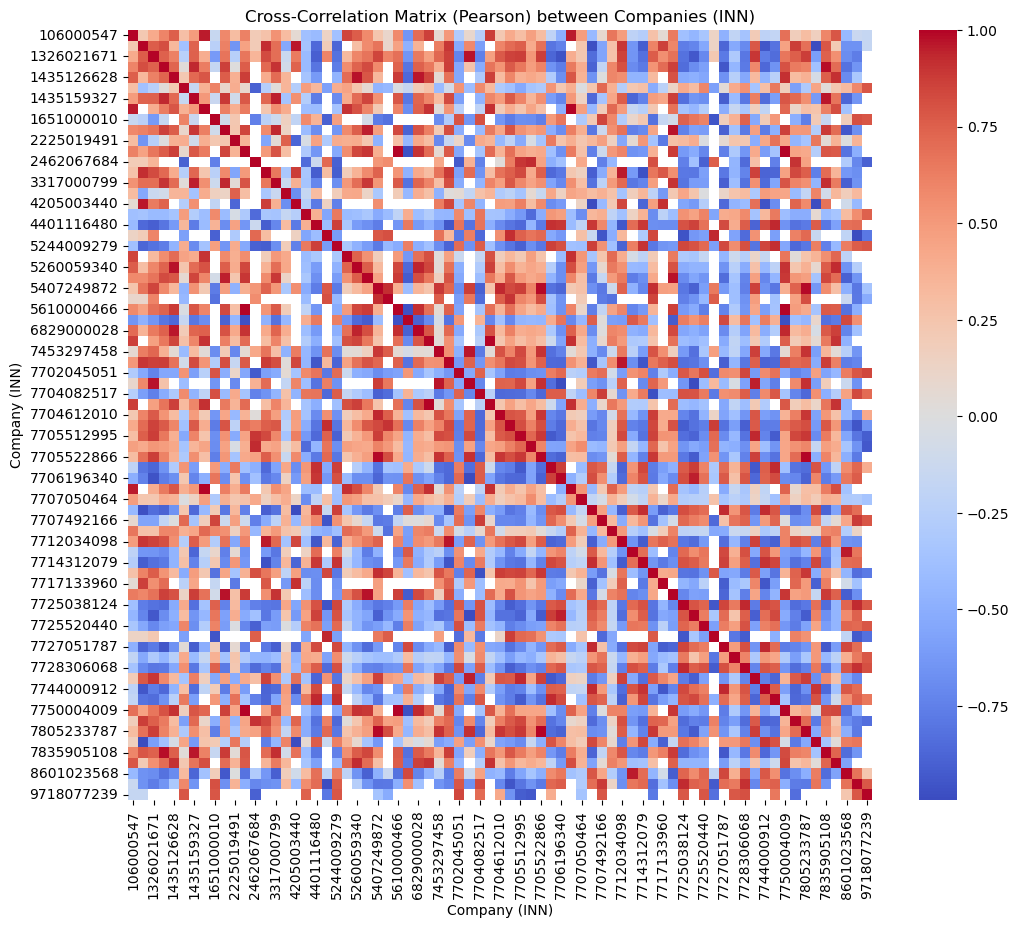

73 73


In [805]:
# === Шаг 3. Вычисление кросс-корреляционной матрицы ===
cross_corr_matrix = pivot_df.corr(method="spearman")  # Можно заменить на 'spearman' или 'kendall', 'pearson'
# cross_corr_matrix = cross_corr_matrix.dropna(axis=0)  # Удалить строки, где все значения NaN
# cross_corr_matrix = cross_corr_matrix.dropna(axis=1)  # Удалить столбцы, где все значения NaN
# === Шаг 4. Вывод результатов ===
print("Cross-Correlation Matrix (Pearson) between Companies (INN):")
print(cross_corr_matrix)

# === Шаг 5. Визуализация через тепловую карту ===
plt.figure(figsize=(12, 10))
sns.heatmap(cross_corr_matrix, cmap="coolwarm")
plt.title("Cross-Correlation Matrix (Pearson) between Companies (INN)")
plt.xlabel("Company (INN)")
plt.ylabel("Company (INN)")
plt.show()
print(len(cross_corr_matrix.index), len(cross_corr_matrix.columns))

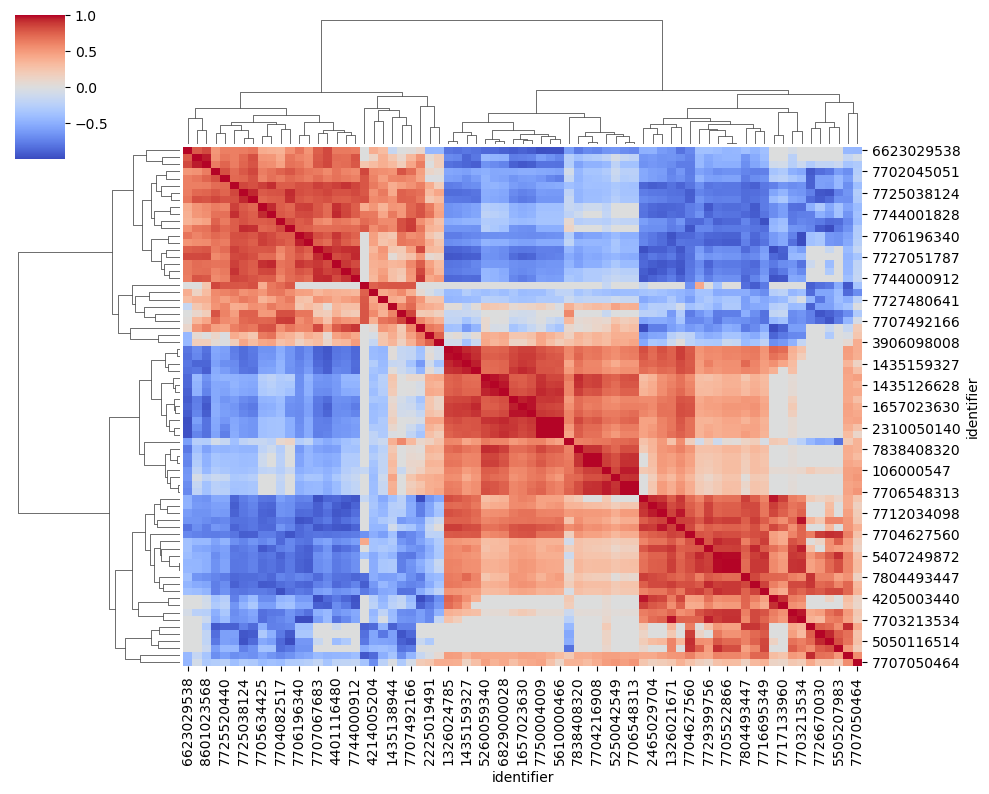

In [807]:
sns.clustermap(cross_corr_matrix.fillna(0), cmap='coolwarm', figsize=(10, 8))
plt.show()

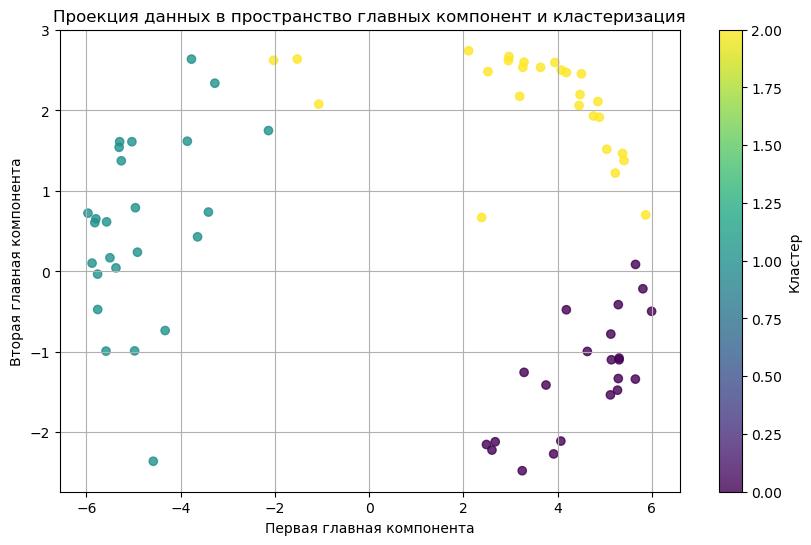

Топ-5 компаний по вкладу в главные компоненты: ['6829000028', '7707492166', '5260059340', '6623029538', '7750004009']
Топ-5 плохих компаний по вкладу в главные компоненты: ['7707050464', '4214005204', '7727480641', '7705513090', '7744000912']


In [813]:
# Применяем SVD для выделения главных компонент
n_components = 2  # Берем две главные компоненты
svd = TruncatedSVD(n_components=n_components, random_state=42)
X_reduced = svd.fit_transform(cross_corr_matrix.fillna(0))

# Оцениваем, какие компании сильнее всего связаны с главными компонентами
components = svd.components_
importance = np.abs(components).sum(axis=0)
top_companies = cross_corr_matrix.columns[np.argsort(importance)[-5:]]  # Топ-5 компаний по вкладу
bad_companies = cross_corr_matrix.columns[np.argsort(importance)[:5]]  # Топ-5 bad компнаний по вкладу
# Нормализация перед кластеризацией
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_reduced)

# Кластеризация с помощью KMeans
n_clusters = 3  # Можно подобрать оптимальное число кластеров
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
labels = kmeans.fit_predict(X_scaled)

# Визуализация результатов
plt.figure(figsize=(10, 6))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=labels, cmap='viridis', alpha=0.8)
plt.xlabel("Первая главная компонента")
plt.ylabel("Вторая главная компонента")
plt.title("Проекция данных в пространство главных компонент и кластеризация")
plt.colorbar(label="Кластер")
plt.grid()
plt.show()

# Выводим компании, которые сильнее всего связаны с главными компонентами
print("Топ-5 компаний по вкладу в главные компоненты:", list(top_companies))
print("Топ-5 плохих компаний по вкладу в главные компоненты:", list(bad_companies))

In [815]:
# Оцениваем вклад компаний в главные компоненты (по абсолютному значению)
importance = np.abs(pca.components_[0])  # Берём 1-ю главную компоненту
bottom_companies = cross_corr_matrix.columns[np.argsort(importance)[:5]]  # Топ-5 с наименьшим вкладом

# Дополнительно проверим дисперсию рейтинга
rating_variance = pivot_df.var()
low_variance_companies = rating_variance.nsmallest(5).index  # Компании с минимальной дисперсией

# Выведем результат
print("Топ-5 компаний с наименьшим вкладом в главные компоненты:", list(bottom_companies))
print("Топ-5 компаний с минимальной дисперсией рейтинга:", list(low_variance_companies))

NameError: name 'pca' is not defined

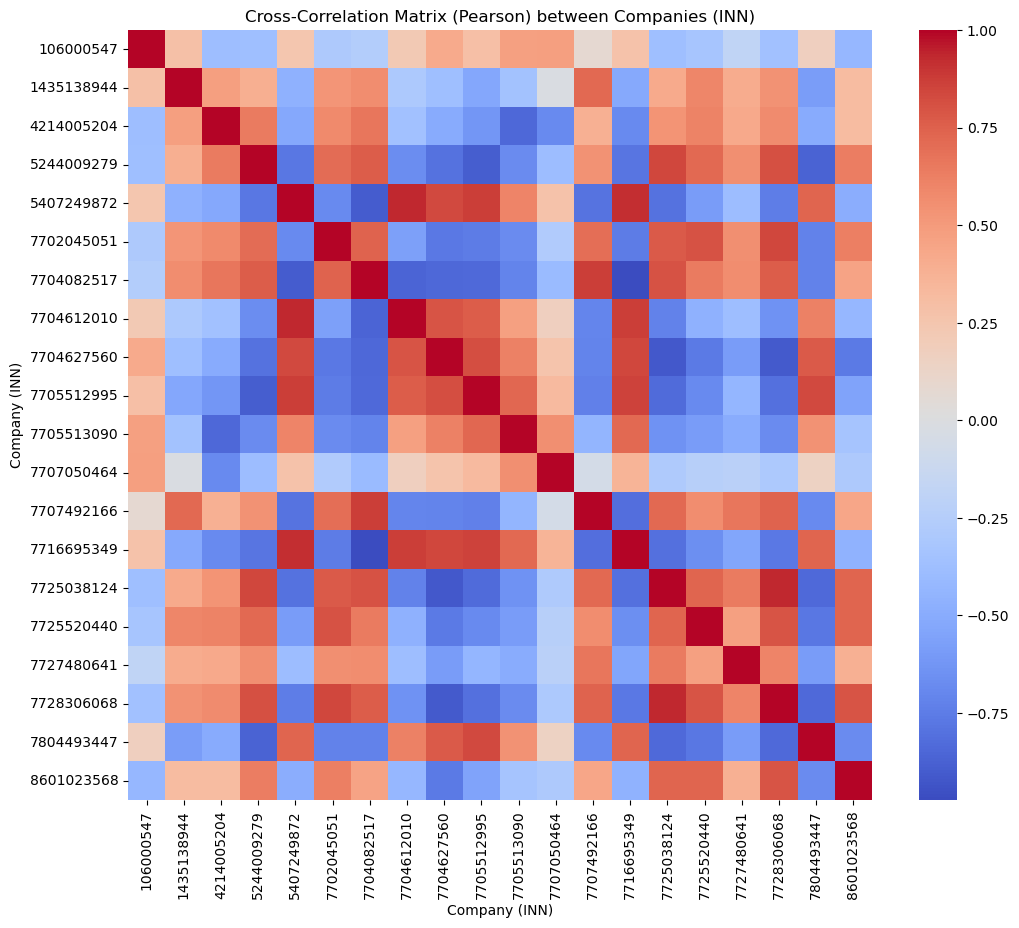

In [744]:
nan_indices = cross_corr_matrix.isna().any(axis=1)  # Идентификаторы с NaN
valid_indices = cross_corr_matrix.index[~nan_indices]  # Только корректные идентификаторы

# Формируем симметричную матрицу
cross_corr_matrix = cross_corr_matrix.loc[valid_indices, valid_indices]


# === Шаг 5. Визуализация через тепловую карту ===
plt.figure(figsize=(12, 10))
sns.heatmap(cross_corr_matrix, cmap="coolwarm")
plt.title("Cross-Correlation Matrix (Pearson) between Companies (INN)")
plt.xlabel("Company (INN)")
plt.ylabel("Company (INN)")
plt.show()

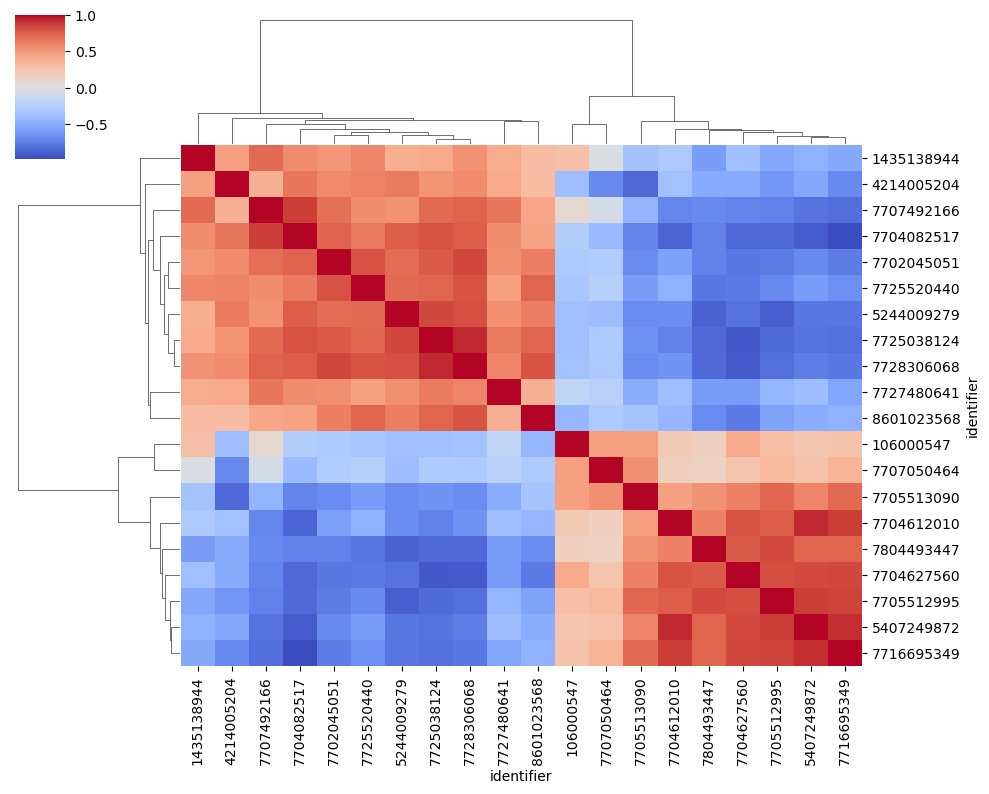

In [745]:
sns.clustermap(cross_corr_matrix.fillna(0), cmap='coolwarm', figsize=(10, 8))
plt.show()

In [746]:
len(cross_corr_matrix.columns), len(cross_corr_matrix.index)

(20, 20)

In [747]:
U, S, Vt = np.linalg.svd(cross_corr_matrix)

In [748]:
U, S, Vt

(array([[-1.01691867e-01, -5.41910738e-01, -2.64331440e-01,
         -1.34298590e-01,  1.09394337e-01, -7.97195218e-02,
          3.40176600e-01,  4.56983366e-01,  2.53526129e-01,
          3.95562010e-01, -1.39643092e-01, -3.30245304e-02,
          9.82811633e-03, -1.35017638e-01,  2.17198824e-02,
          6.35369566e-02,  8.92324973e-03,  6.42371780e-03,
          2.53051196e-02, -1.66177964e-02],
        [ 1.61575229e-01, -3.50115058e-01, -2.69204740e-01,
         -4.20831783e-01,  2.18506441e-01, -1.56578952e-01,
         -3.58694844e-02, -3.21708558e-01, -2.95824346e-01,
         -1.31466303e-01, -2.01946962e-02,  3.36903121e-01,
         -2.12947621e-02,  1.37840885e-01,  1.92920681e-02,
         -2.46194195e-01, -1.67123512e-01,  1.26171763e-01,
         -1.69368202e-01,  2.30255896e-01],
        [ 1.96733568e-01,  2.84643063e-01, -4.01154423e-01,
         -2.30921429e-01,  1.22842418e-01,  6.68040905e-02,
         -6.54758687e-03, -1.86111621e-01,  3.21069693e-02,
          2.

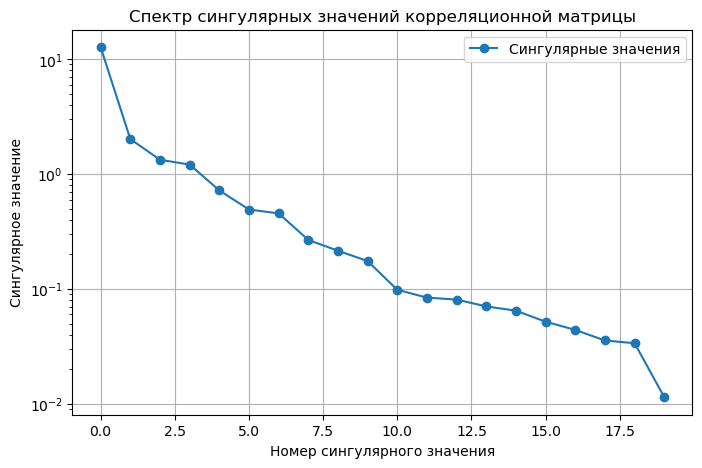

[0.63002157 0.73006177 0.79613492 0.85612977 0.89186859]


In [749]:
# Строим спектр сингулярных значений
plt.figure(figsize=(8, 5))
plt.plot(S, marker="o", linestyle="-", label="Сингулярные значения")
plt.yscale("log")
plt.xlabel("Номер сингулярного значения")
plt.ylabel("Сингулярное значение")
plt.title("Спектр сингулярных значений корреляционной матрицы")
plt.legend()
plt.grid()
plt.show()

# Доля информации, объясняемая первыми 5 сингулярными значениями
explained_variance = np.cumsum(S) / np.sum(S)
print(explained_variance[:5])


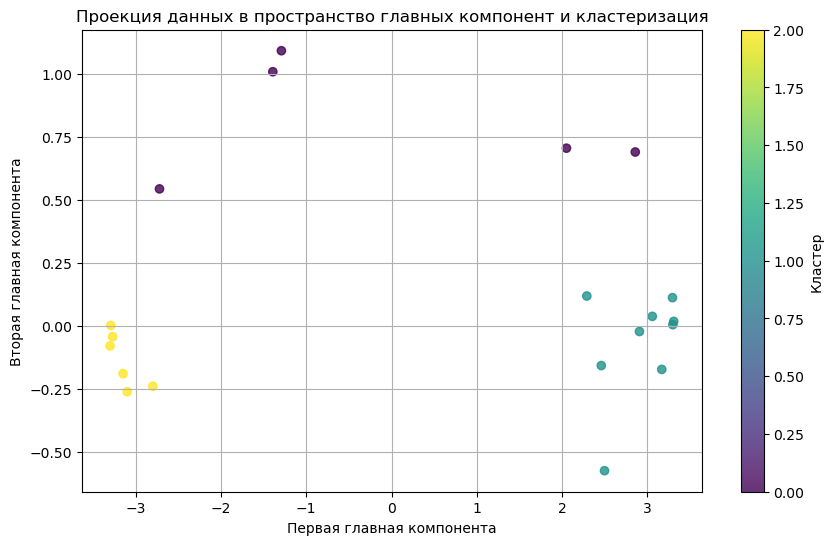

Топ-5 компаний по вкладу в главные компоненты: ['7705513090', '1435138944', '7707492166', '7707050464', '106000547']


In [801]:
# Применяем SVD для выделения главных компонент
n_components = 2  # Берем две главные компоненты
svd = TruncatedSVD(n_components=n_components, random_state=42)
X_reduced = svd.fit_transform(cross_corr_matrix)

# Оцениваем, какие компании сильнее всего связаны с главными компонентами
components = svd.components_
importance = np.abs(components).sum(axis=0)
top_companies = cross_corr_matrix.columns[np.argsort(importance)[-5:]]  # Топ-5 компаний по вкладу

# Нормализация перед кластеризацией
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_reduced)

# Кластеризация с помощью KMeans
n_clusters = 3  # Можно подобрать оптимальное число кластеров
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
labels = kmeans.fit_predict(X_scaled)

# Визуализация результатов
plt.figure(figsize=(10, 6))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=labels, cmap='viridis', alpha=0.8)
plt.xlabel("Первая главная компонента")
plt.ylabel("Вторая главная компонента")
plt.title("Проекция данных в пространство главных компонент и кластеризация")
plt.colorbar(label="Кластер")
plt.grid()
plt.show()

# Выводим компании, которые сильнее всего связаны с главными компонентами
print("Топ-5 компаний по вкладу в главные компоненты:", list(top_companies))